<a href="https://colab.research.google.com/github/abinayaa123/ME592/blob/main/Final%20Project/Bidirectional_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Description

Data sourced from:
https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan 

Training and test data is taken from source. Data is from turbofan simulation.

Each training or test data set (four are provided for each) contains various trajectories (simulations) each of which is run for multiple cycles. The remaining useful life ("RUL") metric is the number of cycles remaining until failure.

Training data was generated by running simulation to "failure", so the RUL known. Test data was generated by running the simulation to some arbitrary number of cycles (before failure), so RUL is unknown given just the test set. However, the "real" RUL is provided for the Test data set.

Goal is to accurately predict the remaining useful life ("RUL") for the Test set by training with the Train set. Model must be trained on and will need to predict RUL for each trajectory individually.


# Data Import and Augmentation

Code assumes you have the raw data files stored on your google drive at "drive/MyDrive/ME592/Final/"

In [1]:
#Import libraries
import numpy as np
import pandas as pd
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
from tensorflow import keras
# Highly recommended for time series data
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
# Processing and metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
# keras --2019--> tf.keras
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, TimeDistributed
from google.colab import drive
drive.mount('/content/drive')

# seed random generators for repeatable results
import random
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

Mounted at /content/drive


In [2]:
#Create dataframes
df_train_1=pd.read_table('drive/MyDrive/ME592/Final/train_FD001.txt',delimiter='\s+',header=None)
df_test_1=pd.read_table('drive/MyDrive/ME592/Final/test_FD001.txt',delimiter='\s+',header=None)
df_test_rul_1=pd.read_table('drive/MyDrive/ME592/Final/RUL_FD001.txt',delimiter='\s+',header=None)

df_train_2=pd.read_table('drive/MyDrive/ME592/Final/train_FD002.txt',delimiter='\s+',header=None)
df_test_2=pd.read_table('drive/MyDrive/ME592/Final/test_FD002.txt',delimiter='\s+',header=None)
df_test_rul_2=pd.read_table('drive/MyDrive/ME592/Final/RUL_FD002.txt',delimiter='\s+',header=None)

df_train_3=pd.read_table('drive/MyDrive/ME592/Final/train_FD003.txt',delimiter='\s+',header=None)
df_test_3=pd.read_table('drive/MyDrive/ME592/Final/test_FD003.txt',delimiter='\s+',header=None)
df_test_rul_3=pd.read_table('drive/MyDrive/ME592/Final/RUL_FD003.txt',delimiter='\s+',header=None)

df_train_4=pd.read_table('drive/MyDrive/ME592/Final/train_FD004.txt',delimiter='\s+',header=None)
df_test_4=pd.read_table('drive/MyDrive/ME592/Final/test_FD004.txt',delimiter='\s+',header=None)
df_test_rul_4=pd.read_table('drive/MyDrive/ME592/Final/RUL_FD004.txt',delimiter='\s+',header=None)

In [3]:
# Add Headers
traj_cycle=['Trajectory','CycleNumber']
settings=['Setting{}'.format(i+1) for i in range(0,3)]
sensors=['Sensor{}'.format(i+1) for i in range(0,21)]
variables = settings + sensors
header=traj_cycle+settings+sensors
df_train_1.columns=header
df_test_1.columns=header
df_train_2.columns=header
df_test_2.columns=header
df_train_3.columns=header
df_test_3.columns=header
df_train_4.columns=header
df_test_4.columns=header

In [4]:
# Create cycle counts for each trajectory in training set 1
cycle_counts=df_train_1.groupby("Trajectory").max()
# Create full RUL array
RUL=[]
for k in np.arange(0,len(cycle_counts)):
  temparr=np.arange(cycle_counts.iloc[k,0]-1,-1,-1)
  RUL=np.concatenate((RUL,temparr))
RUL=RUL.astype(int)
#Add RUL array to df
df_train_1['RUL']=RUL

# Find the RUL in each test trajectory (slower method)
df_test_1['RUL'] = ''
for  k in range(0,len(df_test_1)):
  trajectory = df_test_1.iloc[k]['Trajectory']
  cycle = df_test_1.iloc[k]['CycleNumber']
  cycle_max = df_test_1[df_test_1['Trajectory'] == trajectory]['CycleNumber'].max()
  df_test_1.at[k, 'RUL'] = cycle_max - cycle + df_test_rul_1.values[trajectory-1]

In [5]:
# Create cycle counts for each trajectory in training set 2
cycle_counts=df_train_2.groupby("Trajectory").max()
# Create full RUL array
RUL=[]
for k in np.arange(0,len(cycle_counts)):
  temparr=np.arange(cycle_counts.iloc[k,0]-1,-1,-1)
  RUL=np.concatenate((RUL,temparr))
RUL=RUL.astype(int)
#Add RUL array to df
df_train_2['RUL']=RUL

# Find the RUL in each test trajectory (slower method)
df_test_2['RUL'] = ''
for  k in range(0,len(df_test_2)):
  trajectory = df_test_2.iloc[k]['Trajectory']
  cycle = df_test_2.iloc[k]['CycleNumber']
  cycle_max = df_test_2[df_test_2['Trajectory'] == trajectory]['CycleNumber'].max()
  df_test_2.at[k, 'RUL'] = cycle_max - cycle + df_test_rul_2.values[trajectory-1]

In [6]:
# Create cycle counts for each trajectory in training set 3
cycle_counts=df_train_3.groupby("Trajectory").max()
# Create full RUL array
RUL=[]
for k in np.arange(0,len(cycle_counts)):
  temparr=np.arange(cycle_counts.iloc[k,0]-1,-1,-1)
  RUL=np.concatenate((RUL,temparr))
RUL=RUL.astype(int)
#Add RUL array to df
df_train_3['RUL']=RUL

# Find the RUL in each test trajectory (slower method)
df_test_3['RUL'] = ''
for  k in range(0,len(df_test_3)):
  trajectory = df_test_3.iloc[k]['Trajectory']
  cycle = df_test_3.iloc[k]['CycleNumber']
  cycle_max = df_test_3[df_test_3['Trajectory'] == trajectory]['CycleNumber'].max()
  df_test_3.at[k, 'RUL'] = cycle_max - cycle + df_test_rul_3.values[trajectory-1]

In [7]:
# Create cycle counts for each trajectory in training set 4
cycle_counts=df_train_4.groupby("Trajectory").max()
# Create full RUL array
RUL=[]
for k in np.arange(0,len(cycle_counts)):
  temparr=np.arange(cycle_counts.iloc[k,0]-1,-1,-1)
  RUL=np.concatenate((RUL,temparr))
RUL=RUL.astype(int)
#Add RUL array to df
df_train_4['RUL']=RUL

# Find the RUL in each test trajectory (slower method)
df_test_4['RUL'] = ''
for  k in range(0,len(df_test_4)):
  trajectory = df_test_4.iloc[k]['Trajectory']
  cycle = df_test_4.iloc[k]['CycleNumber']
  cycle_max = df_test_4[df_test_4['Trajectory'] == trajectory]['CycleNumber'].max()
  df_test_4.at[k, 'RUL'] = cycle_max - cycle + df_test_rul_4.values[trajectory-1]

Training data is stored in four dataframes (df_train_1 through df_train_4), each containing multiple trajectories, each trajectory containing all provided data (cycle number, settings 1-3, sensors 1-21) along with the manually created Remaining Useful Life ("RUL") column that is the primary prediction objective.

Test data is similarly stored in four dataframes, same headers as training set, except no RUL column.

Test data RUL is stored as a dataframe with one column, each row is the remaining useful life in cycles at the end of the Test data for each trajectory.

Once model is trained, evaluate by predicting the test data sets (df_test_1 through 4) and comparing RUL prediction for each trajectory to known RUL in df_test_rul_1 through _4

# Data Preparation (preprocessing, structuring for models)

## Data Visualization and Investigation

In [ ]:
# With such a complicated dataset, the first task is to evaluate the different
# sensors in order to identify potential key variables or relationships

In [8]:
# First method is to visually examine the data by plotting different settings 
# and sensors against the RUL

# number of trajectories
traj_train_max_4 = df_train_4['Trajectory'].max()
traj_test_max_4 = df_test_4['Trajectory'].max()
traj_train_max_3 = df_train_3['Trajectory'].max()
traj_test_max_3 = df_test_3['Trajectory'].max()
traj_train_max_2 = df_train_2['Trajectory'].max()
traj_test_max_2 = df_test_2['Trajectory'].max()
traj_train_max_1 = df_train_1['Trajectory'].max()
traj_test_max_1 = df_test_1['Trajectory'].max()

## Preprocessing Method 1: Standard Scaler

In [9]:
# data is noisy and not scaled
# use built-in scaling thorugh sklearn.preprocessing.StandardScaler
# The standard score of a sample x is calculated as:
#   z = (x - u) / s
# where u is the mean of the training samples or zero if with_mean=False, and s 
# is the standard deviation of the training samples or one if with_std=False.
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

# GitHub user kpeters standardizes each trajectory individually.
# It is hypothesized that this accounts for each trajectory having 
# small differences in motor and initial wear. 

df_train_1_prep = df_train_1.copy()
df_test_1_prep = df_test_1.copy()
df_train_2_prep = df_train_2.copy()
df_test_2_prep = df_test_2.copy()
df_train_3_prep = df_train_3.copy()
df_test_3_prep = df_test_3.copy()
df_train_4_prep = df_train_4.copy()
df_test_4_prep = df_test_4.copy()

scaler = StandardScaler()

# Standardize for each trajectory
for k in range(1,traj_train_max_4+1):
  scaler.fit(df_train_4.loc[df_train_4['Trajectory'] == k, variables])
  df_train_4_prep.loc[df_train_4_prep['Trajectory'] == k, variables] = scaler.transform(df_train_4.loc[df_train_4['Trajectory'] == k, variables])

for k in range(1,traj_test_max_4+1):
  scaler.fit(df_test_4.loc[df_test_4['Trajectory'] == k, variables])
  df_test_4_prep.loc[df_test_4_prep['Trajectory'] == k, variables] = scaler.transform(df_test_4.loc[df_test_4['Trajectory'] == k, variables])

for k in range(1,traj_train_max_3+1):
  scaler.fit(df_train_3.loc[df_train_3['Trajectory'] == k, variables])
  df_train_3_prep.loc[df_train_3_prep['Trajectory'] == k, variables] = scaler.transform(df_train_3.loc[df_train_3['Trajectory'] == k, variables])

for k in range(1,traj_test_max_3+1):
  scaler.fit(df_test_3.loc[df_test_3['Trajectory'] == k, variables])
  df_test_3_prep.loc[df_test_3_prep['Trajectory'] == k, variables] = scaler.transform(df_test_3.loc[df_test_3['Trajectory'] == k, variables])

for k in range(1,traj_train_max_2+1):
  scaler.fit(df_train_2.loc[df_train_2['Trajectory'] == k, variables])
  df_train_2_prep.loc[df_train_2_prep['Trajectory'] == k, variables] = scaler.transform(df_train_2.loc[df_train_2['Trajectory'] == k, variables])

for k in range(1,traj_test_max_2+1):
  scaler.fit(df_test_2.loc[df_test_2['Trajectory'] == k, variables])
  df_test_2_prep.loc[df_test_2_prep['Trajectory'] == k, variables] = scaler.transform(df_test_2.loc[df_test_2['Trajectory'] == k, variables])

for k in range(1,traj_train_max_1+1):
  scaler.fit(df_train_1.loc[df_train_1['Trajectory'] == k, variables])
  df_train_1_prep.loc[df_train_1_prep['Trajectory'] == k, variables] = scaler.transform(df_train_1.loc[df_train_1['Trajectory'] == k, variables])

for k in range(1,traj_test_max_1+1):
  scaler.fit(df_test_1.loc[df_test_1['Trajectory'] == k, variables])
  df_test_1_prep.loc[df_test_1_prep['Trajectory'] == k, variables] = scaler.transform(df_test_1.loc[df_test_1['Trajectory'] == k, variables])


## Preprocessing Method 2: Rolling Average

In [ ]:
# prepare data
df_train_1_smooth = df_train_1_prep.copy()
df_test_1_smooth = df_test_1_prep.copy()

df_train_2_smooth = df_train_2_prep.copy()
df_test_2_smooth = df_test_2_prep.copy()

df_train_3_smooth = df_train_3_prep.copy()
df_test_3_smooth = df_test_3_prep.copy()

df_train_4_smooth = df_train_4_prep.copy()
df_test_4_smooth = df_test_4_prep.copy()

In [ ]:
# Standardize for each trajectory
for k in range(1,traj_train_max_1+1):
  df_train_1_smooth.loc[df_train_1_smooth['Trajectory'] == k, variables] = df_train_1_smooth.loc[df_train_1_smooth['Trajectory'] == k, variables].rolling(10).mean()

for k in range(1,traj_train_max_1+1):
  df_test_1_smooth.loc[df_test_1_smooth['Trajectory'] == k, variables] = df_test_1_smooth.loc[df_test_1_smooth['Trajectory'] == k, variables].rolling(10).mean()

for k in range(1,traj_train_max_2+1):
  df_train_2_smooth.loc[df_train_2_smooth['Trajectory'] == k, variables] = df_train_2_smooth.loc[df_train_2_smooth['Trajectory'] == k, variables].rolling(10).mean()

for k in range(1,traj_train_max_2+1):
  df_test_2_smooth.loc[df_test_2_smooth['Trajectory'] == k, variables] = df_test_2_smooth.loc[df_test_2_smooth['Trajectory'] == k, variables].rolling(10).mean()

for k in range(1,traj_train_max_3+1):
  df_train_3_smooth.loc[df_train_3_smooth['Trajectory'] == k, variables] = df_train_3_smooth.loc[df_train_3_smooth['Trajectory'] == k, variables].rolling(10).mean()

for k in range(1,traj_train_max_3+1):
  df_test_3_smooth.loc[df_test_3_smooth['Trajectory'] == k, variables] = df_test_3_smooth.loc[df_test_3_smooth['Trajectory'] == k, variables].rolling(10).mean()

for k in range(1,traj_train_max_4+1):
  df_train_4_smooth.loc[df_train_4_smooth['Trajectory'] == k, variables] = df_train_4_smooth.loc[df_train_4_smooth['Trajectory'] == k, variables].rolling(10).mean()

for k in range(1,traj_train_max_4+1):
  df_test_4_smooth.loc[df_test_4_smooth['Trajectory'] == k, variables] = df_test_4_smooth.loc[df_test_4_smooth['Trajectory'] == k, variables].rolling(10).mean()

In [ ]:
# drop NA rows - this takes away some data but is necessary
df_train_1_smooth = df_train_1_smooth.dropna()
df_test_1_smooth = df_test_1_smooth.dropna()

df_train_2_smooth = df_train_2_smooth.dropna()
df_test_2_smooth = df_test_2_smooth.dropna()

df_train_3_smooth = df_train_3_smooth.dropna()
df_test_3_smooth = df_test_3_smooth.dropna()

df_train_4_smooth = df_train_4_smooth.dropna()
df_test_4_smooth = df_test_4_smooth.dropna()

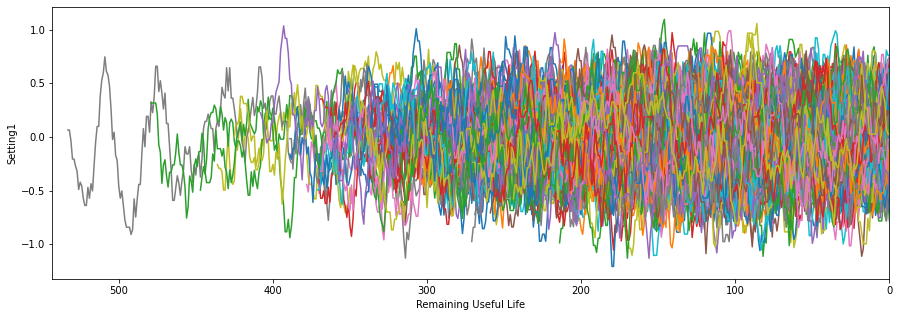

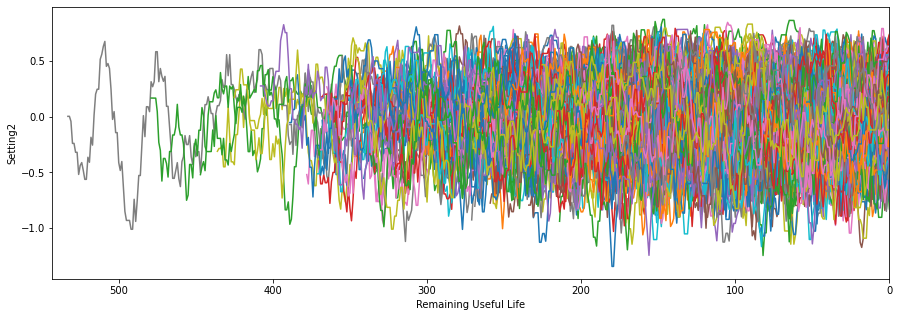

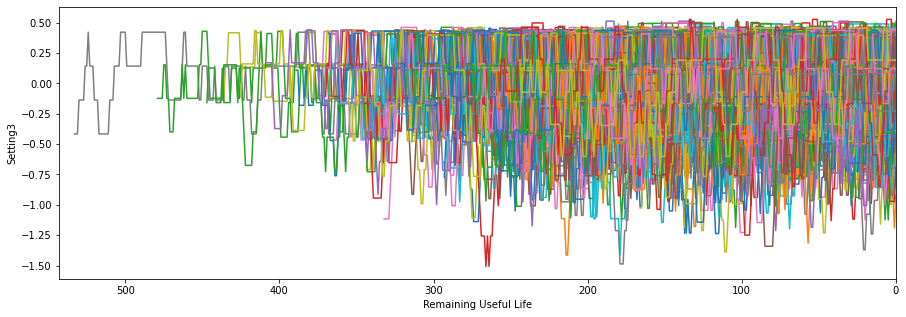

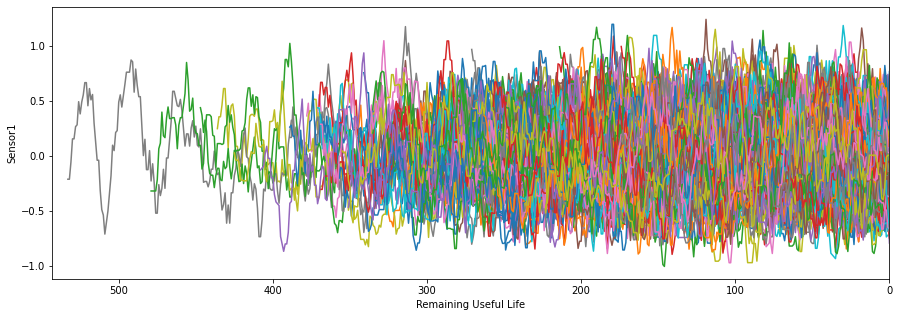

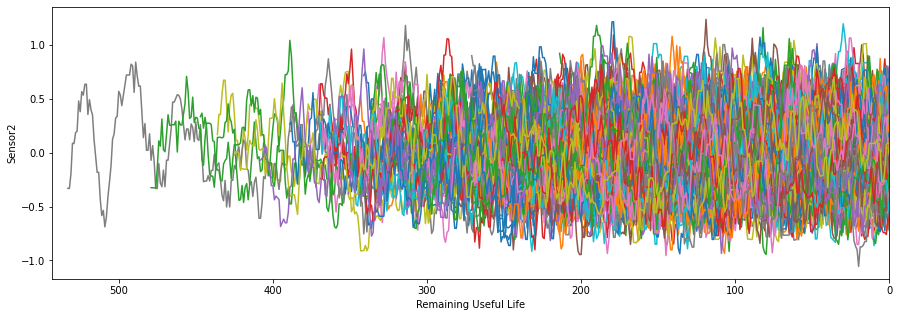

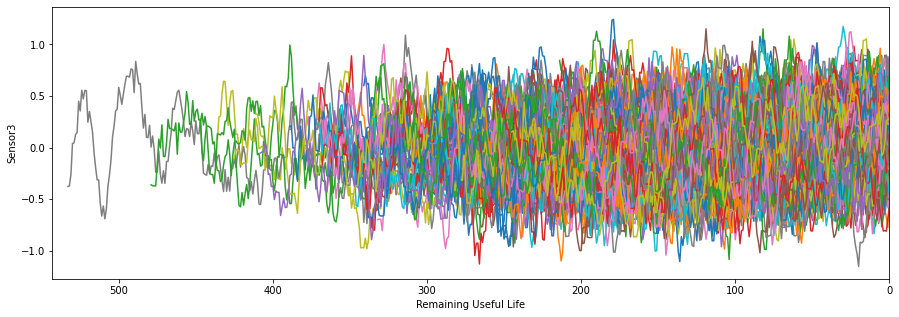

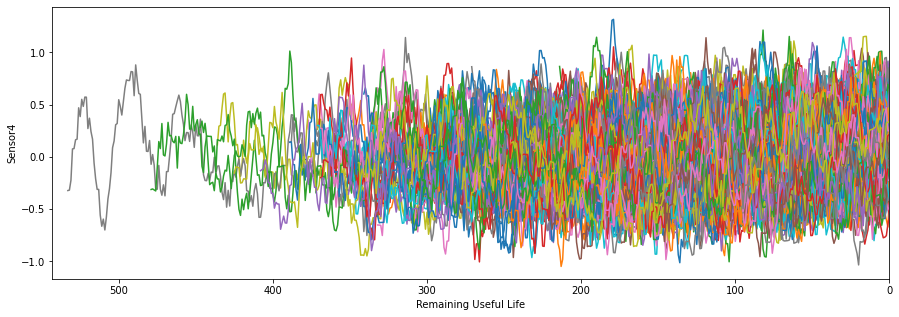

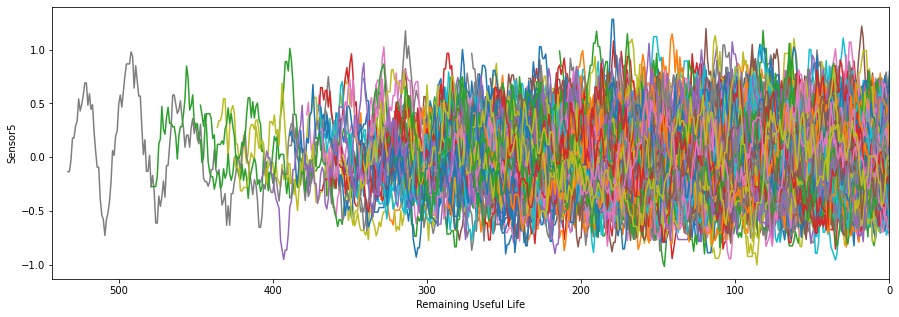

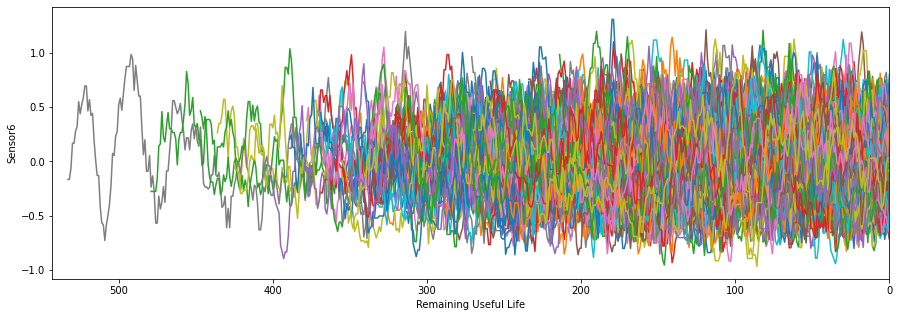

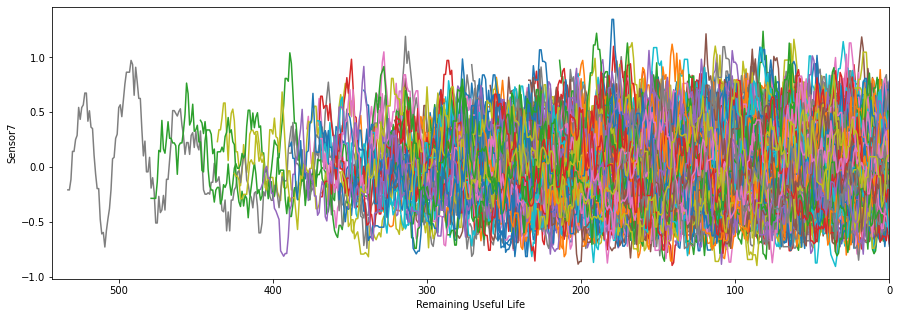

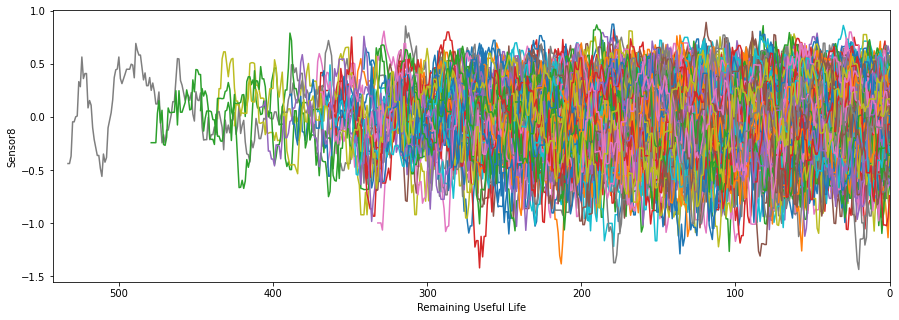

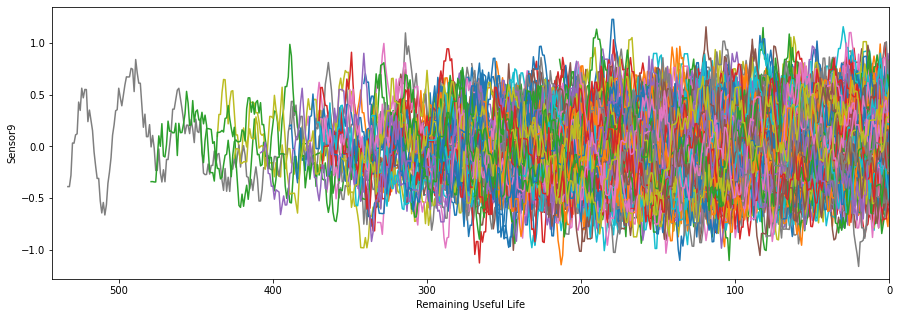

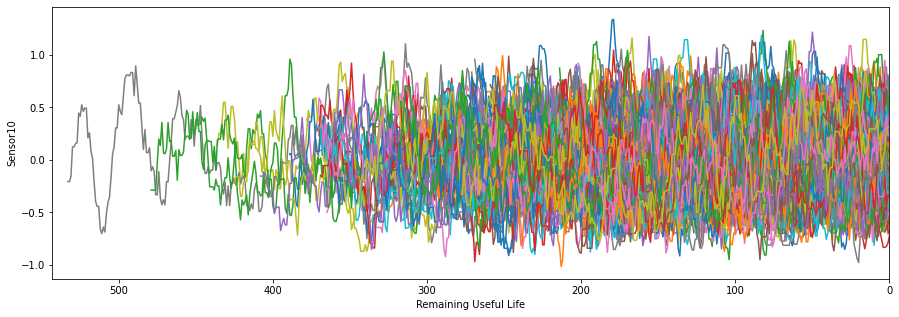

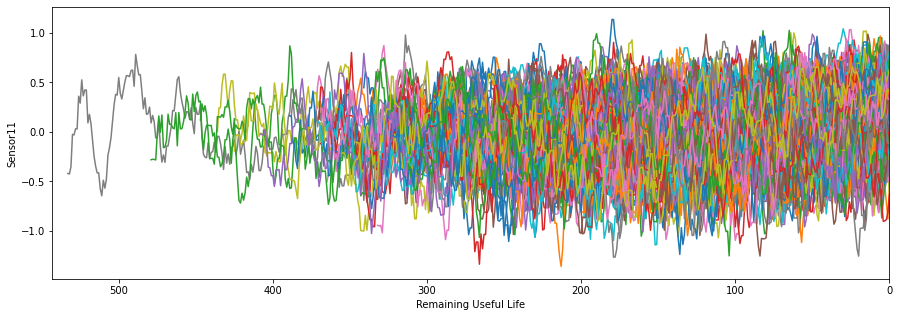

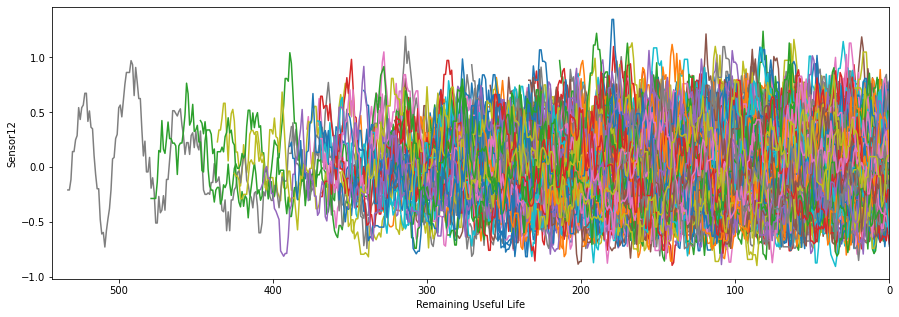

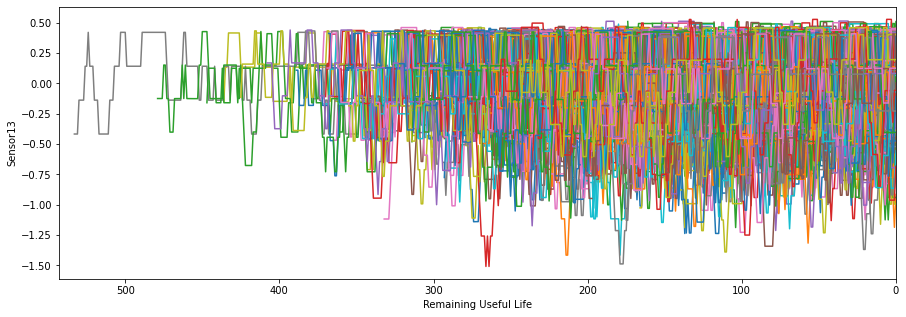

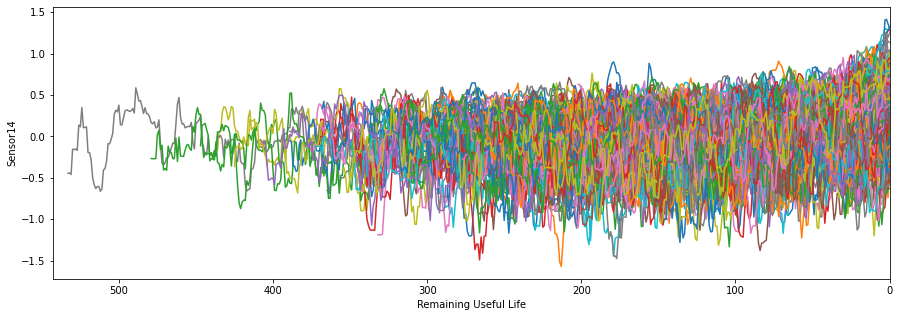

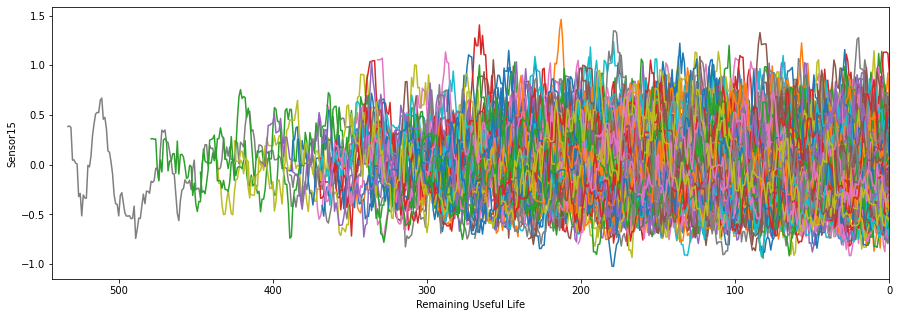

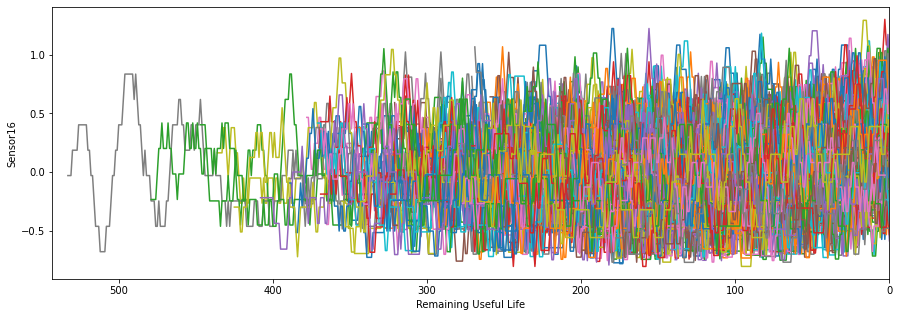

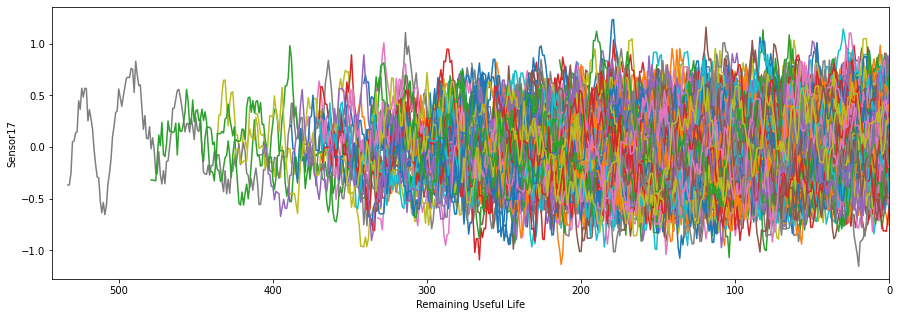

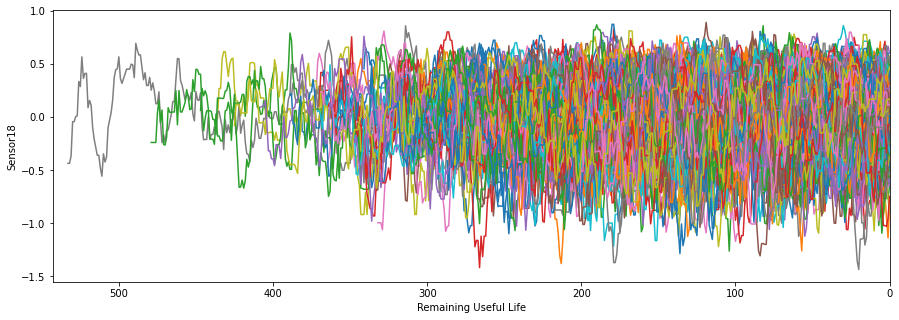

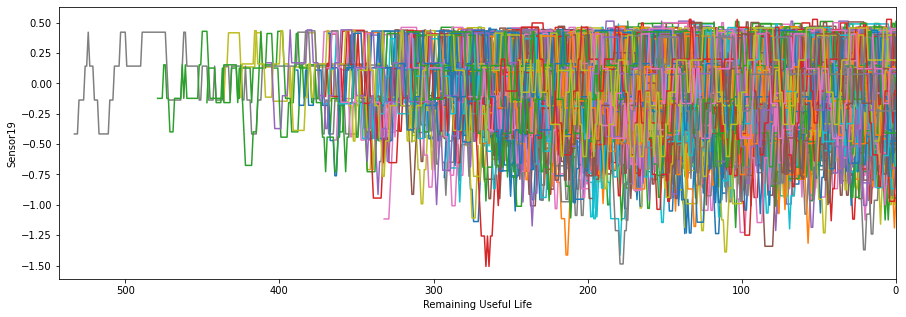

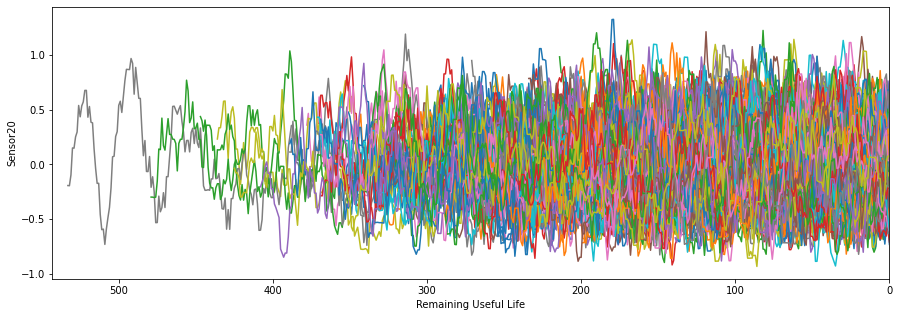

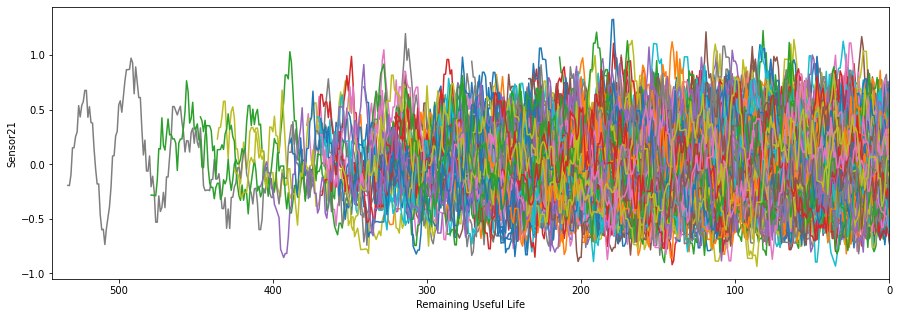

In [ ]:
# plot all settings and sensors for each training trajectory
for i in range(0,len(variables)):
  plt.figure(figsize=(15,5))
  for k in range(1,traj_train_max_4+1):
    traj_k = df_train_4_smooth[df_train_4_smooth['Trajectory'] == k]
    sensor = traj_k[variables[i]]
    RUL_temp = traj_k['RUL']
    plt.plot(RUL_temp, sensor)
  plt.xlim(df_train_4_smooth['CycleNumber'].max(), 0)  # reverse the x-axis so RUL counts down to zero
  plt.ylabel(variables[i])
  plt.xlabel('Remaining Useful Life')
  plt.show()

## Preprocessing Method 3: Identify Key Sensors

In [ ]:
# The third method of preprocessing is to identify key sensors, then remove the 
# remainder to evaluate if performance is impacted. Based on the initial data
# visualization and investigation, sensors 1, 5, 6, 8, 13, 16, 18, and 19 do
# not exhibit any change over the course of each trajectory.

# This leaves the key sensors as 2, 3, 4, 7, 9, 10, 11, 12, 14, 15, 17, 20, and
# 21


In [ ]:
df_train_1_key = df_train_1_prep.copy()
df_test_1_key = df_test_1_prep.copy()
df_train_2_key = df_train_2_prep.copy()
df_test_2_key = df_test_2_prep.copy()
df_train_3_key = df_train_3_prep.copy()
df_test_3_key = df_test_3_prep.copy()
df_train_4_key = df_train_4_prep.copy()
df_test_4_key = df_test_4_prep.copy()

df_train_1_key = df_train_1_key.drop(['Sensor1','Sensor5','Sensor6','Sensor8',
                                      'Sensor13','Sensor16','Sensor18','Sensor19',], axis=1)
df_test_1_key = df_test_1_key.drop(['Sensor1','Sensor5','Sensor6','Sensor8',
                                      'Sensor13','Sensor16','Sensor18','Sensor19',], axis=1)
df_train_2_key = df_train_2_key.drop(['Sensor1','Sensor5','Sensor6','Sensor8',
                                      'Sensor13','Sensor16','Sensor18','Sensor19',], axis=1)
df_test_2_key = df_test_2_key.drop(['Sensor1','Sensor5','Sensor6','Sensor8',
                                      'Sensor13','Sensor16','Sensor18','Sensor19',], axis=1)
df_train_3_key = df_train_3_key.drop(['Sensor1','Sensor5','Sensor6','Sensor8',
                                      'Sensor13','Sensor16','Sensor18','Sensor19',], axis=1)
df_test_3_key = df_test_3_key.drop(['Sensor1','Sensor5','Sensor6','Sensor8',
                                      'Sensor13','Sensor16','Sensor18','Sensor19',], axis=1)
df_train_4_key = df_train_4_key.drop(['Sensor1','Sensor5','Sensor6','Sensor8',
                                      'Sensor13','Sensor16','Sensor18','Sensor19',], axis=1)
df_test_4_key = df_test_4_key.drop(['Sensor1','Sensor5','Sensor6','Sensor8',
                                      'Sensor13','Sensor16','Sensor18','Sensor19',], axis=1)

# Bidirectional LSTM

## Data Preparation

In [150]:
# the datasets defined here as all_train and all_test can be changed based on 
# which dataset is being evaluated
all_train = df_train_4_prep
all_test = df_test_4_prep

all_train = all_train.drop(traj_cycle, axis = 1)
all_test = all_test.drop(traj_cycle, axis = 1)

# ensure all data is float
values_train = all_train.values
values_train = values_train.astype('float32')

values_test = all_test.values
values_test = values_test.astype('float32')

In [135]:
# prepare data for lstm
# convert series to supervised learning  --> spaced out the data
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True): # create 1 time lag
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1): # shift to hist. according to n_in
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out): # shift to future according to n_out
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [151]:
# specify the number of lag observations
n_lag = 3
#n_features = len(all_train.columns) - 1 #len(variables)
n_features = len(variables)
# frame as supervised learning
reframed_train = series_to_supervised(values_train, n_lag, 1)
reframed_test = series_to_supervised(values_test, n_lag, 1)

In [152]:
# split into train and validation sets. 
# train on  0-80% of data set 
# validate on 80-100% of data set 
end_train = round(0.8*len(reframed_train))

values = reframed_train.values
train = values[:end_train, :]
val = values[end_train:, :]
test = reframed_test.values

# split into input and outputs
n_obs = n_lag * n_features # count in the 24 features, lag = 3
train_X, train_y = train[:, :n_obs], train[:, -1] # take only the occupancy as output
test_X, test_y = test[:, :n_obs], test[:, -1] # take only the occupancy as output
val_X,val_y = val[:, :n_obs], val[:, -1]
print(train_X.shape, train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_lag, n_features))
test_X = test_X.reshape((test_X.shape[0], n_lag, n_features))
val_X = val_X.reshape((val_X.shape[0], n_lag, n_features))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape)
print(test_X.shape, test_y.shape)

(48997, 72) (48997,)
(48997, 3, 24) (48997,) (12249, 3, 24) (12249,)
(41211, 3, 24) (41211,)


## Model Training

In [138]:
#we use a bidirectional LSTM layer along with usual LSTM layers and build a RNN model for predicting RUL
from keras.layers.wrappers import Bidirectional
def create_model():
  model= tf.keras.Sequential([
            tf.keras.layers.Bidirectional(layers.LSTM(256,return_sequences = True), input_shape=(train_X.shape[1], train_X.shape[2])),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Bidirectional(layers.LSTM(128,return_sequences = True)),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Bidirectional(layers.LSTM(64,return_sequences = True)),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.LSTM(units = 50),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(units = 1,activation='relu')                
          ])
  
  adam = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer = 'adam', loss = 'mean_squared_error')

  return model

with tf.device('/device:GPU:0'):
#with tpu_strategy.scope():
  model = create_model()

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_21 (Bidirecti  (None, 3, 512)           575488    
 onal)                                                           
                                                                 
 dropout_28 (Dropout)        (None, 3, 512)            0         
                                                                 
 bidirectional_22 (Bidirecti  (None, 3, 256)           656384    
 onal)                                                           
                                                                 
 dropout_29 (Dropout)        (None, 3, 256)            0         
                                                                 
 bidirectional_23 (Bidirecti  (None, 3, 128)           164352    
 onal)                                                           
                                                      

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [139]:
history = model.fit(train_X, train_y, epochs=100,batch_size=128,validation_data=(val_X, val_y),verbose=2)

Epoch 1/100
383/383 - 23s - loss: 21851.7227 - val_loss: 17583.3887 - 23s/epoch - 60ms/step
Epoch 2/100
383/383 - 5s - loss: 17849.1523 - val_loss: 14360.4355 - 5s/epoch - 14ms/step
Epoch 3/100
383/383 - 5s - loss: 14916.1670 - val_loss: 11949.8926 - 5s/epoch - 14ms/step
Epoch 4/100
383/383 - 5s - loss: 12739.0605 - val_loss: 10205.5303 - 5s/epoch - 14ms/step
Epoch 5/100
383/383 - 5s - loss: 11178.0195 - val_loss: 8988.3594 - 5s/epoch - 14ms/step
Epoch 6/100
383/383 - 5s - loss: 10108.7988 - val_loss: 8188.8789 - 5s/epoch - 14ms/step
Epoch 7/100
383/383 - 5s - loss: 9424.7617 - val_loss: 7704.3818 - 5s/epoch - 14ms/step
Epoch 8/100
383/383 - 5s - loss: 8988.5801 - val_loss: 7438.5225 - 5s/epoch - 14ms/step
Epoch 9/100
383/383 - 5s - loss: 8762.3242 - val_loss: 7315.8286 - 5s/epoch - 14ms/step
Epoch 10/100
383/383 - 5s - loss: 8689.6484 - val_loss: 7267.7983 - 5s/epoch - 14ms/step
Epoch 11/100
383/383 - 5s - loss: 8629.1445 - val_loss: 7256.9248 - 5s/epoch - 14ms/step
Epoch 12/100
383/3

In [140]:
import os
#os.chdir('drive/MyDrive/ME592/Final/') #change link to access data from your repository
# serialize model to JSON
model_json = model.to_json()
with open("bi-LSTM_model_4.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("bi-LSTM_model_4.h5")
print("Saved model to disk")

Saved model to disk


## Evaluation

### Training and Test Loss

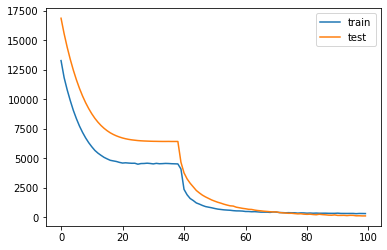

Test RMSE: 19.102


In [68]:
# plot history (preprocessing method 1 and trained with train dataset 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show() 

# make a prediction
Pred_y = model.predict(test_X)

# calculate RMSE
rmse = sqrt(mean_squared_error(Pred_y, test_y))
print('Test RMSE: %.3f' % rmse)

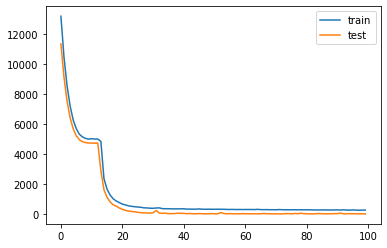

Test RMSE: 25.297


In [96]:
# plot history (preprocessing method 1 and trained with train dataset 2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show() 

# make a prediction
Pred_y = model.predict(test_X)

# calculate RMSE
rmse = sqrt(mean_squared_error(Pred_y, test_y))
print('Test RMSE: %.3f' % rmse)

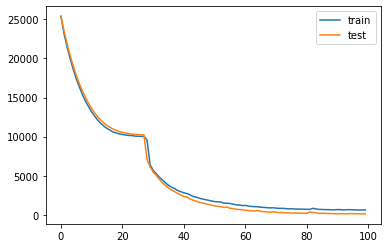

Test RMSE: 19.397


In [116]:
# plot history (preprocessing method 1 and trained with train dataset 3)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show() 

# make a prediction
Pred_y = model.predict(test_X)

# calculate RMSE
rmse = sqrt(mean_squared_error(Pred_y, test_y))
print('Test RMSE: %.3f' % rmse)

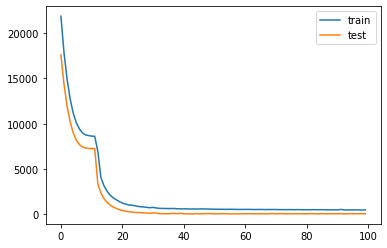

Test RMSE: 19.612


In [141]:
# plot history (preprocessing method 1 and trained with train dataset 4)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show() 

# make a prediction
Pred_y = model.predict(test_X)

# calculate RMSE
rmse = sqrt(mean_squared_error(Pred_y, test_y))
print('Test RMSE: %.3f' % rmse)

### Evaluating on other test datasets

In [153]:
# make a prediction
Pred_y = model.predict(test_X)

# calculate RMSE
rmse = sqrt(mean_squared_error(Pred_y, test_y))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 24.609


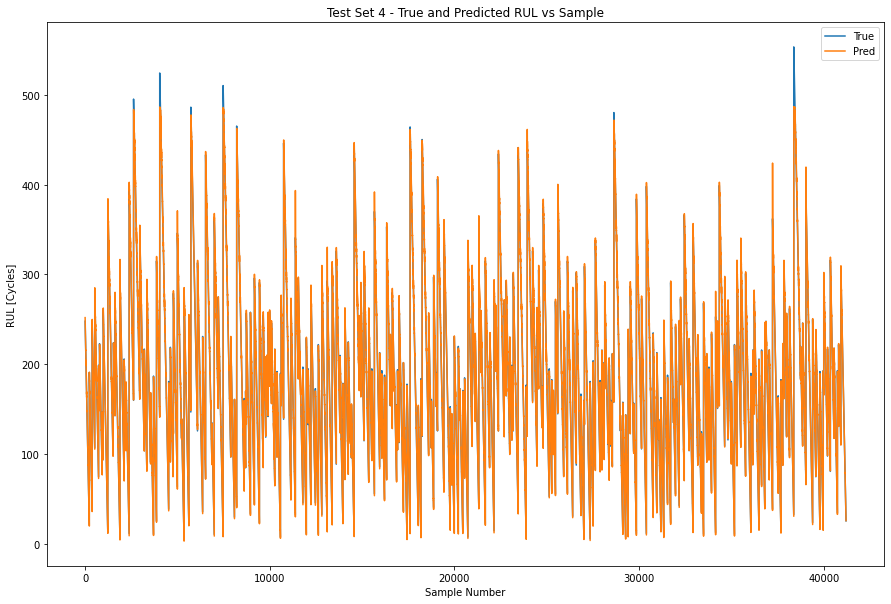

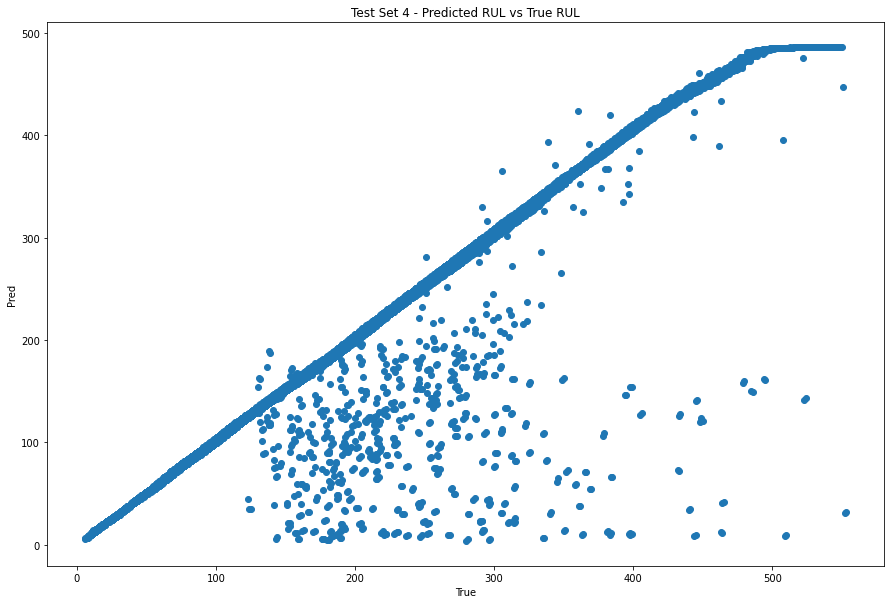

In [ ]:
# plot prediction and real result
plt.figure(figsize=(15,10))
plt.plot(test_y, label='True')
plt.plot(Pred_y, label='Pred')
plt.ylabel('RUL [Cycles]')
plt.xlabel('Sample Number')
plt.title('Test Set 4 - True and Predicted RUL vs Sample')
plt.legend()

plt.figure(figsize=(15,10))
plt.scatter(test_y,Pred_y)
plt.ylabel('Pred')
plt.xlabel('True')
plt.title('Test Set 4 - Predicted RUL vs True RUL')
plt.show()

In [ ]:
# add placeholder for three empty first rows to make the row numbers line up
p = np.array([['NA'], ['NA'], ['NA']])
Pred_y_shift = np.vstack((p, Pred_y))
df_test_pred_4 = df_test_4.assign(Pred_RUL = Pred_y_shift)
Pred_y_last = df_test_pred_4.groupby('Trajectory').last().reset_index().astype('float32')

# calculate RMSE on final RUL values for each trajectory
rmse = sqrt(mean_squared_error(Pred_y_last.Pred_RUL, df_test_rul_4))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.711
